In [1]:
import os
import sys
import numpy as np
import pandas as pd
import importlib
from shutil import rmtree, copy, copytree
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['DejaVu Serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.size'] = 10
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = True
rcParams['mathtext.default'] = 'regular'
rcParams['text.usetex'] = False


from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from casatasks import listobs, split, clearcal, delmod, rmtables, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, fixvis, phaseshift, casalog, mstransform, exportfits
from casatools import componentlist, msmetadata, imager, ms, table

### Set basepath for file and log storage and specify MS

In [52]:
# Set path for measurement set, analysis output, and CASA log files
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-02-14T12_30-13_30/'
casalog.setlogfile(f'{basepath}/casa_logfile.log')

idx = 0
msfiles = [file for file in os.listdir(basepath) if file.endswith('base.ms')]
#for file in msfiles:
#    copytree(os.path.join(basepath, file), os.path.join(basepath, file.split(".ms")[0]+'_base.ms'))
msfile = msfiles[idx]
print(f'Base MS File: {msfile}')

chanstoavg = 4

Base MS File: 2025-02-14T13:02:18_ra222.7_dec+71.7_base.ms


### Save MS for imaging & average over N frequency channels

In [53]:
msfile_image = msfile.split(".ms")[0][:-5]+f'_image_sb{chanstoavg}.ms'
print(f'Imaging MS File: {msfile_image}')

Imaging MS File: 2025-02-14T13:02:18_ra222.7_dec+71.7_image_sb4.ms


In [54]:
if not os.path.exists(os.path.join(basepath, msfile_image)):
    #copytree(os.path.join(basepath, msfile_image), os.path.join(basepath, msfile_image))
    split(vis=os.path.join(basepath, msfile), outputvis=os.path.join(basepath, msfile_image), datacolumn='all', width=chanstoavg)

### Save MS for calibration & average over N frequency channels

In [55]:
msfile_phasebcal = msfile.split(".ms")[0][:-5]+f'_phasebcal_sb{chanstoavg}.ms'
print(f'MS File to rephase to bandpass calibrator: {msfile_phasebcal}')

MS File to rephase to bandpass calibrator: 2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4.ms


In [57]:
if not os.path.exists(os.path.join(basepath, msfile_phasebcal)):
    #copytree(os.path.join(basepath, msfile_image), os.path.join(basepath, msfile_phasebcal))
    split(vis=os.path.join(basepath, msfile), outputvis=os.path.join(basepath, msfile_phasebcal), datacolumn='all', width=chanstoavg)

### Specify sub-field

In [75]:
msmd = msmetadata()
msmd.open(os.path.join(basepath, msfile))
fieldnames = msmd.fieldnames()

field_image_idx = 8
fieldname_image = fieldnames[field_image_idx]
field_cal_idx0, field_cal_idx1 = 6, 11
fieldname_cal_list = fieldnames[field_cal_idx0: field_cal_idx1]
fieldname_cal = ', '.join(fieldname_cal_list)

print(f'Field Name (Image): {fieldname_image}')
print(f'Field Names (Calibration): {fieldname_cal}')

Field Name (Image): drift_ra14h49m57s
Field Names (Calibration): drift_ra14h49m31s, drift_ra14h49m44s, drift_ra14h49m57s, drift_ra14h50m10s, drift_ra14h50m23s


### Clear all but the data columns for all MS's

In [63]:
print('Reset base MS...')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile)+'.flagversions')
print('\n')

print('Reset imaging MS...')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile_image))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile_image))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile_image) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile_image), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile_image)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile_image)+'.flagversions')
print('\n')

print('Reset phasebcal MS...')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile_phasebcal))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile_phasebcal))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile_phasebcal) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile_phasebcal), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile_phasebcal)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile_phasebcal)+'.flagversions')

Reset base MS...
Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-01 05:03:18	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags


Reset imaging MS...
Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-01 05:03:23	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags


Reset phasebcal MS...
Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-01 05:03:25	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags


### Flag RFI in the imaging and calibration MS's

In [64]:
fieldtoflag = fieldname_cal

print('Flagging Data for RFI in imaging MS...')
tfcrop_pars = {'timecutoff':3.5, 'freqcutoff':3, 'maxnpieces':1, 'growfreq':25, 'combinescans':True, 'ntime':'300s'}
flagdata(vis=os.path.join(basepath, msfile_image), field=fieldtoflag, mode='tfcrop', datacolumn='data', action='apply', display='none', flagbackup=False, **tfcrop_pars)

print('Flagging Data for RFI in calibration MS...')
tfcrop_pars = {'timecutoff':3.5, 'freqcutoff':3, 'maxnpieces':1, 'growfreq':25, 'combinescans':True, 'ntime':'300s'}
flagdata(vis=os.path.join(basepath, msfile_phasebcal), field=fieldtoflag, mode='tfcrop', datacolumn='data', action='apply', display='none', flagbackup=False, **tfcrop_pars)

Flagging Data for RFI in imaging MS...
Flagging Data for RFI in calibration MS...


{}

### Check Flagged Data in Calibration MS

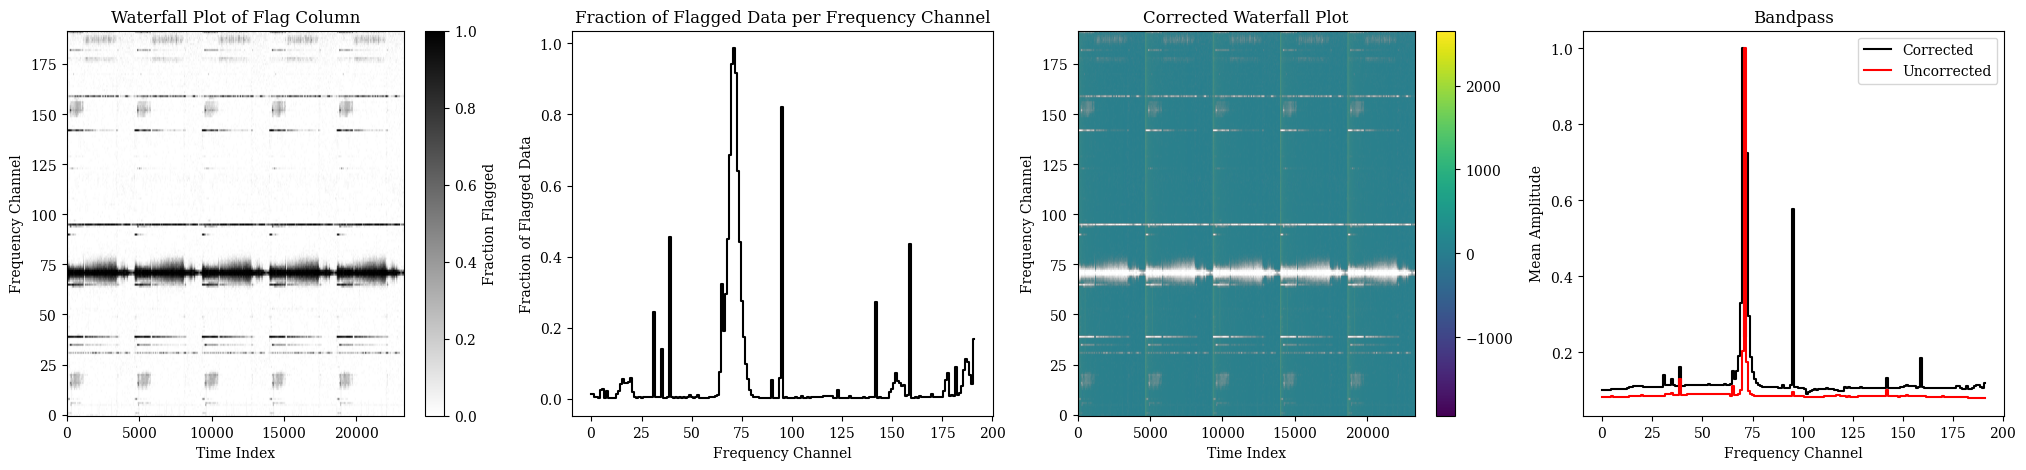

In [71]:
# Open the measurement set
ms_tool = ms()
ms_tool.open(os.path.join(basepath, msfile_phasebcal))
ms_tool.msselect({'field':fieldname_cal})
# Retrieve the data and flag columns
data = ms_tool.getdata(['data', 'flag'])
flags = data['flag'] # boolean flags
vis = data['data'] # complex visibilities
ms_tool.close()

# If there are multiple polarizations, average them to get a fraction flagged.
# Note: flags are boolean, so averaging converts them to a fractional value.
if flags.shape[0] > 1:
    flag_avg = np.mean(flags, axis=0)
else:
    flag_avg = flags[0]

# Compute the amplitude of the visibilities.
amp = np.abs(vis)  # shape: (npol, nchan, nrow)

# If there are multiple polarizations, combine them.
if amp.shape[0] > 1:
    # For flags, consider a sample flagged if any polarization is flagged.
    flag_mask = np.any(flags, axis=0)  # shape: (nchan, nrow)
    # Average the amplitude over polarizations.
    amp_avg = np.mean(amp, axis=0)       # shape: (nchan, nrow)
else:
    amp_avg = amp[0]
    flag_mask = flags[0]

# Create a masked array that masks out flagged samples.
masked_amp = np.ma.array(amp_avg, mask=flag_mask, fill_value=0.)
# Now, compute the bandpass by averaging over time (axis=1) for each frequency channel,
# ignoring the masked (flagged) samples.
bandpass_arr = np.mean(masked_amp, axis=1)
bandpass_norm = bandpass_arr/np.max(bandpass_arr)
bandpass_uncorr = np.mean(amp_avg, axis=1)
bandpass_uncorr_norm = bandpass_uncorr/np.max(bandpass_uncorr)

# Waterfall Plot

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4,
                                    figsize=(25, 5))
im = ax0.imshow(flag_avg, aspect='auto', origin='lower', cmap='binary')
ax0.set_xlabel('Time Index')
ax0.set_ylabel('Frequency Channel')
ax0.set_title('Waterfall Plot of Flag Column')
plt.colorbar(im, ax=ax0, label='Fraction Flagged')

# Fraction of flagged data per frequency channel (averaged over time)
flag_fraction = np.mean(flag_avg, axis=1)
ax1.plot(flag_fraction, drawstyle='steps-mid', c='k')
ax1.set_xlabel('Frequency Channel')
ax1.set_ylabel('Fraction of Flagged Data')
#ax1.set_xlim(350, 400)
ax1.set_title('Fraction of Flagged Data per Frequency Channel')

amp_mean = np.nanmean(masked_amp)
amp_std = np.nanstd(masked_amp)
im = ax2.imshow(masked_amp, vmin=amp_mean-1*amp_std, vmax=amp_mean+1*amp_std, aspect='auto', origin='lower')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Frequency Channel')
ax2.set_title('Corrected Waterfall Plot')
plt.colorbar(im, ax=ax2)

# Plot the corrected bandpass
ax3.plot(bandpass_norm, drawstyle='steps-mid', c='k', label='Corrected')
ax3.plot(bandpass_uncorr_norm, drawstyle='steps-mid', c='r', label='Uncorrected')
ax3.set_xlabel('Frequency Channel')
ax3.set_ylabel('Mean Amplitude')
#ax2.set_xlim(350, 400)
ax3.set_title('Bandpass')
ax3.legend()

plt.show()


### Search for a bandpass calibrator (brightest NVSS source in the field)

In [76]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import find_calibrators
importlib.reload(find_calibrators)
from find_calibrators import find_calibrator

calibrator_name, calibrator_coord_hms, calibrator_coord_deg, flux_nvss = find_calibrator(basepath, msfile_phasebcal, fieldname=fieldname_image, top_n=1, pbfrac=0.5)
print('________________________________________')
print(f'Calibrator: {calibrator_name}')
print(f'Calibrator Coordinates (hms): {calibrator_coord_hms}')
print(f'Calibrator Coordinates (deg): {calibrator_coord_deg}')
print(f'Calibrator Flux: {flux_nvss} Jy')


Including Primary Beam FWHM (2.946 degrees):
  RA:  221.014849 to 223.960499
  Dec: 70.271330 to 73.216980
Querying VIII/65/nvss ...
     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
145907+714019 14 59 07.63 +71 40 19.9      0.10 ...         <    16.6          
Querying J/A+A/598/A78/table3 ...
No matching TGSS sources.
Calibrator Name: J1459+7140
Coord (deg): 224.78179166666663, 71.67219444444444
Coord (hms): J2000 14h59m07.63s +71d40m19.9s
Flux (Jy): 7.4684
Maj Axis: 17.9arcsec
Min Axis: 16.6arcsec
PA: 0.0deg
Spectral Index: None
________________________________________
Calibrator: J1459+7140
Calibrator Coordinates (hms): J2000 14h59m07.63s +71d40m19.9s
Calibrator Coordinates (deg): (224.78179166666663, 71.67219444444444)
Calibrator Flux: 7.4684 Jy


### Generate Sky Model with the 10 brightest NVSS sources in the field

In [77]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import make_skymodel_cl_mf
importlib.reload(make_skymodel_cl_mf)
from make_skymodel_cl_mf import make_skymodel

# Number of bright sources to include in the sky model
top_n = 10

# Define filename strings
ra_str = f"{msfile.split('_')[1][2:5]}p{msfile.split('_')[1][6:9]}"
dec_str = f"{msfile.split('_')[2][4:6]}p{msfile.split('_')[2][7:8]}"
clfile = f'nvss_top{top_n}_{ra_str}_{dec_str}.cl'
cllabel = clfile.split('.')[0]

if os.path.exists(os.path.join(basepath, f'nvss_top{top_n}_{ra_str}_{dec_str}.cl')):
    rmtree(os.path.join(basepath, f'nvss_top{top_n}_{ra_str}_{dec_str}.cl'))

nvss_catalog = make_skymodel(basepath, msfile_phasebcal, fieldname=fieldname_image, top_n=top_n, pbfrac=0.5)



Primary Beam FWHM (2.946 degrees):
  RA:  221.014849 to 223.960499
  Dec: 70.271330 to 73.216980
Querying VIII/65/nvss/ ...


     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
145907+714019 14 59 07.63 +71 40 19.9      0.10 ...         <    16.6          
144840+701820 14 48 40.87 +70 18 20.3      0.09 ...         <    17.6          
145259+723655 14 52 59.08 +72 36 55.1      0.10 ...         <    19.6          
150251+721814 15 02 51.22 +72 18 14.0      0.10 ...         <    17.1          
150758+722618 15 07 58.91 +72 26 18.3      0.11 ...         <    19.9        P*
145940+730531 14 59 40.26 +73 05 31.0      0.11 ...         <    14.8          
144619+712013 14 46 19.00 +71 20 13.6      0.10 ...         <    17.6          
145006+730758 14 50 06.22 +73 07 58.6      0.11 ...         <    17.9          
145920+711509 14 59 20.04 +71 15 09.9      0.10 ...         <    14.8          
144725+720247 14 47 25.63 +72 02 47.9   

2025-03-01 05:13:35	WARN	componentlist::close	componentlist closed


### Image Sky Model

In [78]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import image_skymodel_cl
importlib.reload(image_skymodel_cl)
from image_skymodel_cl import image_skymodel

wcs_2d_coords_x, wcs_2d_coords_y, phasecenter = image_skymodel(basepath, msfile_phasebcal, fieldname_image, nvss_catalog, top_n=top_n, nx=4800, ny=4800, cellx='3arcsec', celly='3arcsec', mode='mfs', phasecenter=calibrator_coord_hms)

Image Parameters
----------------
nx, ny: (4800, 4800)
cellx, celly: ('3arcsec', '3arcsec')
mode: mfs
Phase Center: J2000 14h59m07.63s +71d40m19.9s
MS Selected: /data/jfaber/dsa110-contimg/sandbox/2025-02-14T12_30-13_30/2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4.ms


2025-03-01 05:13:43	WARN	imager::setdata()	Ignoring that ms/data/jfaber/dsa110-contimg/sandbox/2025-02-14T12_30-13_30/2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4.msspecified here
2025-03-01 05:13:43	WARN	imager::setdata()	Imager was constructed with an ms 
2025-03-01 05:13:43	WARN	imager::setdata()	if multi-ms are to be used please construct imager without parameters and use setdata to specify the ms's and selection
Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Image Shape: (4800, 4800)


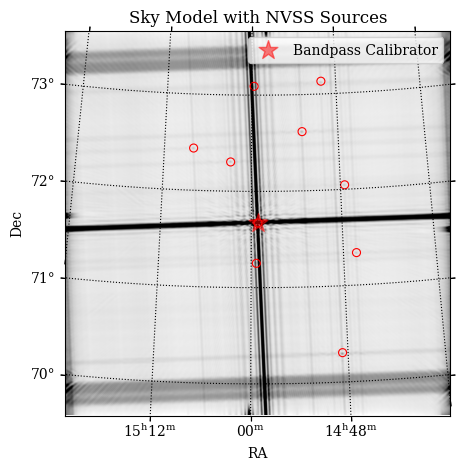

In [79]:
# Load the FITS image
fitsfile = cllabel + '.image.fits'
fits_file = os.path.join(basepath, fitsfile)
hdu = fits.open(fits_file)[0]
print(f'Image Shape: {hdu.data[0, 0, :, :].shape}')
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (5, 5))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

cal_ra_deg, cal_dec_deg = calibrator_coord_deg
cal_coord_x, cal_coord_y = wcs_2d.world_to_pixel_values(cal_ra_deg, cal_dec_deg)
ax.scatter(cal_coord_x, cal_coord_y, marker='*', s=200, c='red', alpha=0.5, label = 'Bandpass Calibrator')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.legend()

# Show the plot
plt.title('Sky Model with NVSS Sources')
plt.grid(color='k', ls='dotted')
plt.show()


### Set calibrator as phase center for fields in calibration MS and sub-band frequency channels by a factor of 16

In [80]:
msfile_phasebcal_cntrd = msfile_phasebcal.split(".ms")[0]+f'_cntrd.ms'

In [86]:
#channelstoavg=16
if os.path.exists(os.path.join(basepath, msfile_phasebcal_cntrd)):
    rmtree(os.path.join(basepath, msfile_phasebcal_cntrd))
    rmtree(os.path.join(basepath, msfile_phasebcal_cntrd.split(".ms")[0]+'.flagversions'))

mstransform(vis=os.path.join(basepath, msfile_phasebcal), outputvis=os.path.join(basepath, msfile_phasebcal_cntrd), phasecenter=calibrator_coord_hms)

### Place sky model in the MODEL column of the calibration MS

In [87]:
#for fieldname in field_names:      
ft(vis=os.path.join(basepath, msfile_phasebcal_cntrd), 
      field=fieldname_cal,
      complist=os.path.join(basepath, clfile), 
      reffreq='1.4GHz',
      usescratch=True)

In [32]:
#print('Generating Sky Model...')
#
#if os.path.exists(os.path.join(basepath, bpclfile)):
#      print(f"File '{bpclfile}' already exists. Skipping component creation.")
#else:
#      print(f"Creating new bandpass calibrator component list '{bpclfile}'...")
#
#      cl = componentlist()
#
#      cl.addcomponent(
#            dir=calibrator_coord,
#            flux=6.0508,
#            fluxunit='Jy',
#            freq='1.4GHz')
#            #shape='Gaussian',
#            #majoraxis='30arcsec',
#            #minoraxis='30arcsec',
#            #positionangle='0deg')
#
#      cl.rename(os.path.join(basepath, bpclfile))
#      cl.close()
#
#print('Inserting Sky Model...')
#
#ft(vis=os.path.join(basepath, msfile), 
#      complist=os.path.join(basepath, bpclfile), 
#      field='',
#      reffreq='1.4GHz',
#      usescratch=True)

### Perform bandpass calibration on the calibration MS

In [ ]:
print('Performing Bandpass Calibration...')
print('\n')

#bcalfield = fieldname
bcalfield = fieldname_cal

if bcalfield is None:

    bcalfile = f'{calibrator_name}_allfields.bcal'

    bandpass(vis=os.path.join(basepath, msfile_phasebcal_cntrd),
            field='',
            caltable=os.path.join(basepath, bcalfile),
            refant='pad103',
            solint='inf',
            bandtype='B',
            combine='scan, obs, field',
            uvrange='>0.3klambda')

else:
    
    bcalfile = f'{calibrator_name}_f{field_cal_idx0}f{field_cal_idx1}.bcal'

    bandpass(vis=os.path.join(basepath, msfile_phasebcal_cntrd),
            field=bcalfield,
            caltable=os.path.join(basepath, bcalfile),
            refant='pad103',
            solint='inf',
            bandtype='B',
            combine='scan, obs, field',
            uvrange='>0.3klambda')

Performing Bandpass Calibration...


3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=191) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=190) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=189) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=188) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=187) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=186) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=185) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=184) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=183) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=182) at 2025/02/14/13:04:02.7
3 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=181) at 2025/02/14/13:04:02.7
3 of 1

In [89]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import check_ants
importlib.reload(check_ants)
from check_ants import compute_antenna_quality

# Run the improved quality check on the calibration table
#cal_table = os.path.join(basepath, bcalfile)
ant_stats, bad_antennas = compute_antenna_quality(os.path.join(basepath, bcalfile))
#print(f"\nIdentified {len(bad_antennas)} bad antennas: {bad_antennas}")
ant_add_pad = ['pad' + str(i+1) for i in bad_antennas]
ant_names = ', '.join(ant_add_pad)
print(f'\nIdentified {len(bad_antennas)} bad antennas: {ant_names}')

Antenna Quality Summary:
   Antenna         Med Amp        MAD(amp)      n_sol      Valid(amp) |       Med Phase      MAD(phase)      n_sol    Valid(phase)   Amp Dev (MAD)
------------------------------------------------------------------------------------------------------------------------
         0          1.5579          0.0484        192            0.99 |         23.8961         33.5884        192            0.99            0.54
         1          1.4655          0.0394        192            0.99 |        166.2131         61.7568        192            1.00            0.48
         2          1.5861          0.0565        192            0.99 |        151.5674        121.6670        192            1.00            0.85
         3          1.5884          0.0586        192            0.99 |        168.8978         48.7550        192            1.00            0.87
         4          1.4251          0.0513        192            0.99 |         39.6011         46.5827        192     

In [34]:
#flagdata(vis=os.path.join(basepath, msfile), spw='0:230~320')
#flagdata(vis=os.path.join(basepath, msfile), spw='0:595~620')
#flagdata(vis=os.path.join(basepath, msfile), mode='manual', antenna='pad4, pad5, pad6, pad7, pad8, pad10, pad21, pad22, pad23, pad25, pad26, pad27, pad28, pad30, pad31, pad32, pad33, pad34, pad35, pad36, pad37, pad48, pad52, pad53, pad54, pad55, pad56, pad57, pad58, pad59, pad60, pad61, pad62, pad63, pad64, pad65, pad66, pad67, pad117')
#flagdata(vis=os.path.join(basepath, msfile), mode='manual', autocorr=True, flagbackup=False)
#flagdata(vis=os.path.join(basepath, msfile), mode='shadow', tolerance=0.0, flagbackup=False)
#flagdata(vis=os.path.join(basepath, msfile), mode='clip', clipzeros=True, flagbackup=False)

In [35]:
#print('Performing Phase Only Calibration...')
#print('\n')
#
#pcalfile = f'{cllabel}.gcal.p'
## Solve for phase, usually on a longer solint, in this case 'inf'.
#gaincal(vis=os.path.join(basepath, msfile),
#        field='',
#        caltable=os.path.join(basepath, pcalfile),
#        solint='inf',
#        refant='pad103',
#        combine='scan, obs, field',
#        solnorm=True,
#        calmode='p', # 'p' = phase-only
#        gaintype='G',
#        gaintable = [os.path.join(basepath, bcalfile)]
#      )

### Apply bandpass calibration solutions

In [91]:
applycal(vis=os.path.join(basepath, msfile_phasebcal_cntrd),
         field=fieldname_cal,
         gaintable=os.path.join(basepath, bcalfile))

### Flag antennas based on bandpass solutions

In [92]:
flagdata(vis=os.path.join(basepath, msfile_phasebcal_cntrd), mode='manual', antenna=ant_names)
flagdata(vis=os.path.join(basepath, msfile_phasebcal_cntrd), mode='manual', autocorr=True, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_phasebcal_cntrd), mode='shadow', tolerance=0.0, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_phasebcal_cntrd), mode='clip', clipzeros=True, flagbackup=False)

2025-03-01 05:24:17	WARN	FlagDataHandler::preLoadColumn (file /source/casa6/casatools/src/code/flagging/Flagging/FlagDataHandler.cc, line 989)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.


{}

In [38]:
#msfile_corr = msfile.split(".ms")[0]+'_corr.ms'
#split(vis=os.path.join(basepath, msfile), datacolumn='corrected', outputvis=os.path.join(basepath, msfile_corr), width=16)

In [39]:
#applycal(vis=os.path.join(basepath, msfile),
#         field='',
#         gaintable=os.path.join(basepath, phase_table),
#         interp='linear',
#         applymode='calflag',
#         calwt=False)  # Usually set to False for typical continuum

In [40]:
#amp_table = f'{cllabel}.gcal.a'
## Solve for amplitude, usually on a longer solint, in this case 'inf'.
#gaincal(vis=os.path.join(basepath, msfile),
#        field='',
#        caltable=os.path.join(basepath, amp_table),
#        solint='inf',
#        refant='pad103',
#        combine='scan, field',
#        solnorm=True,
#        calmode='a', # 'a' = amplitude-only
#        gaintype='G',
#        gaintable = [os.path.join(basepath, bp_table), os.path.join(basepath, phase_table)]
#      ) 
#

In [41]:
#applycal(vis=os.path.join(basepath, msfile),
#         field='',
#         gaintable=os.path.join(basepath, amp_table),
#         interp='linear',
#         applymode='calflag',
#         calwt=False)  # Usually set to False for typical continuum

In [93]:
os.chdir(basepath)
#for fieldname in field_names[11]:
imsize_x, imsize_y = 4800, 4800
cell_res = '3arcsec'
weighttype = 'briggs'
weight = 0.5
imagetype = f'dirty_{weighttype}{weight}_{imsize_x}x{cell_res[:4]}'
imagename = f'{msfile_phasebcal_cntrd.split(".ms")[0]}_f{field_cal_idx0}f{field_cal_idx1}_{imagetype}'
tclean(vis=os.path.join(basepath, msfile_phasebcal_cntrd),
       field=fieldname_cal,            
       imagename=os.path.join(basepath, imagename),
       specmode='mfs',
       deconvolver='hogbom',
       gridder='wproject',
       wprojplanes=-1,  # auto (if using wproject)
       niter=0,             
       threshold='0.005Jy',
       interactive=False,
       imsize=[imsize_x, imsize_y],
       cell=[cell_res], 
       weighting=weighttype,
       robust=weight,
       pblimit=0.25,
       psfcutoff=0.5,
       uvrange='>0.3klambda',
       phasecenter=phasecenter)


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2025-03-01 05:27:26	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2284)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [5.493624687194824],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.005Jy',
 'stopDescription': 'Zero iterations performed'}

In [94]:
exportfits(os.path.join(basepath, imagename) + '.image', os.path.join(basepath, imagename) + '.image.fits')

Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


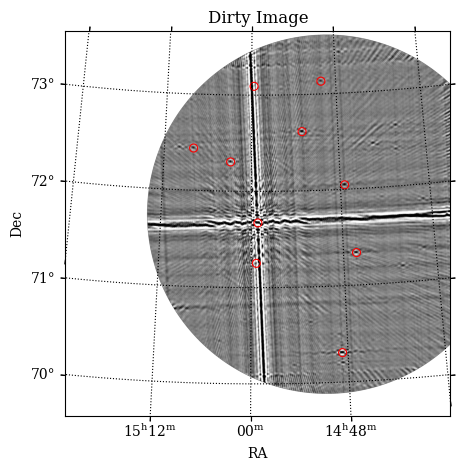

In [95]:
# Load the FITS image
#for fieldname in field_names:
fitsfile = os.path.join(basepath, imagename) + '.image.fits'
fits_file = os.path.join(basepath, fitsfile)
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (5, 5))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Dirty Image')
plt.grid(color='k', ls='dotted')
plt.show()


Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


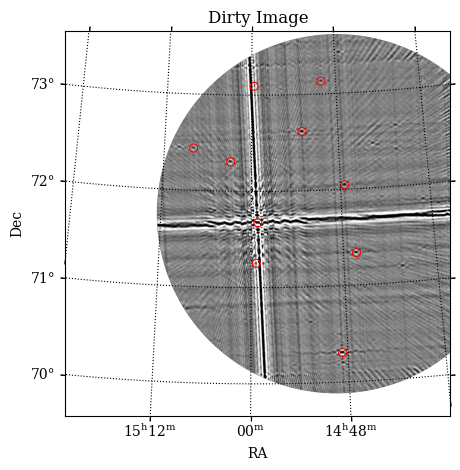

In [96]:
# Load the FITS image
#for fieldname in field_names:
#fitsfile = os.path.join(basepath, imagename) + '.image.fits'
#fits_file = os.path.join(basepath, fitsfile)
fits_file = '2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4_cntrd_f0f5_dirty_briggs0.5_4800x3arc.image.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (5, 5))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Dirty Image')
plt.grid(color='k', ls='dotted')
plt.show()


In [97]:
from casatools import linearmosaic

In [103]:
lm = linearmosaic()

lm.setlinmostype('optimal')

lm.defineoutputimage(nx=4800, ny=4800, cellx='3arcsec', celly='3arcsec', \
        imagecenter = phasecenter, #01h37m41.299431s 33d09m35.132990s', #set to calibrator coordinates
        outputimage='mosaic_test.linmos', \
        outputweight = 'mosaic_test.weightlinmos')

input_images = ['2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4_cntrd_f0f5_dirty_briggs0.5_4800x3arc.image', '2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4_cntrd_f6f11_dirty_briggs0.5_4800x3arc.image']
pb_images = ['2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4_cntrd_f0f5_dirty_briggs0.5_4800x3arc.pb', '2025-02-14T13:02:18_ra222.7_dec+71.7_phasebcal_sb4_cntrd_f6f11_dirty_briggs0.5_4800x3arc.pb']

lm.makemosaic(images=input_images, weightimages=pb_images)

True

In [105]:
exportfits('mosaic_test.linmos', 'mosaic_test.linmos.fits')

Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


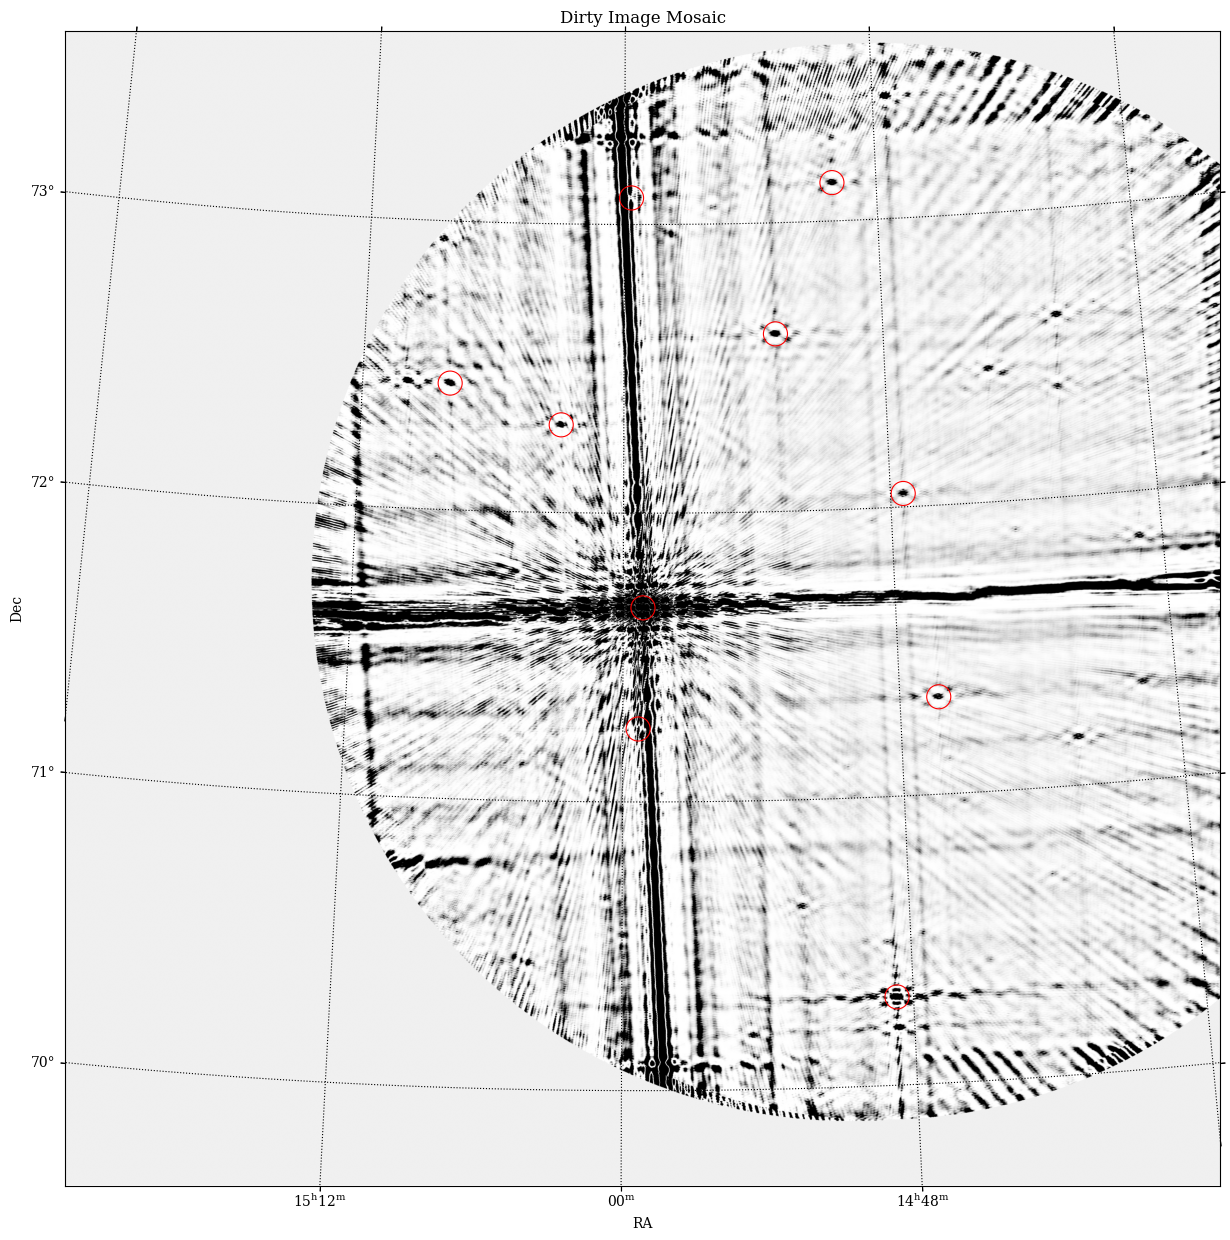

In [108]:
# Load the FITS image
#for fieldname in field_names:
#fitsfile = os.path.join(basepath, imagename) + '.image.fits'
#fits_file = os.path.join(basepath, fitsfile)
fits_file = 'mosaic_test.linmos.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (15, 15))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Dirty Image Mosaic')
plt.grid(color='k', ls='dotted')
plt.show()


Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


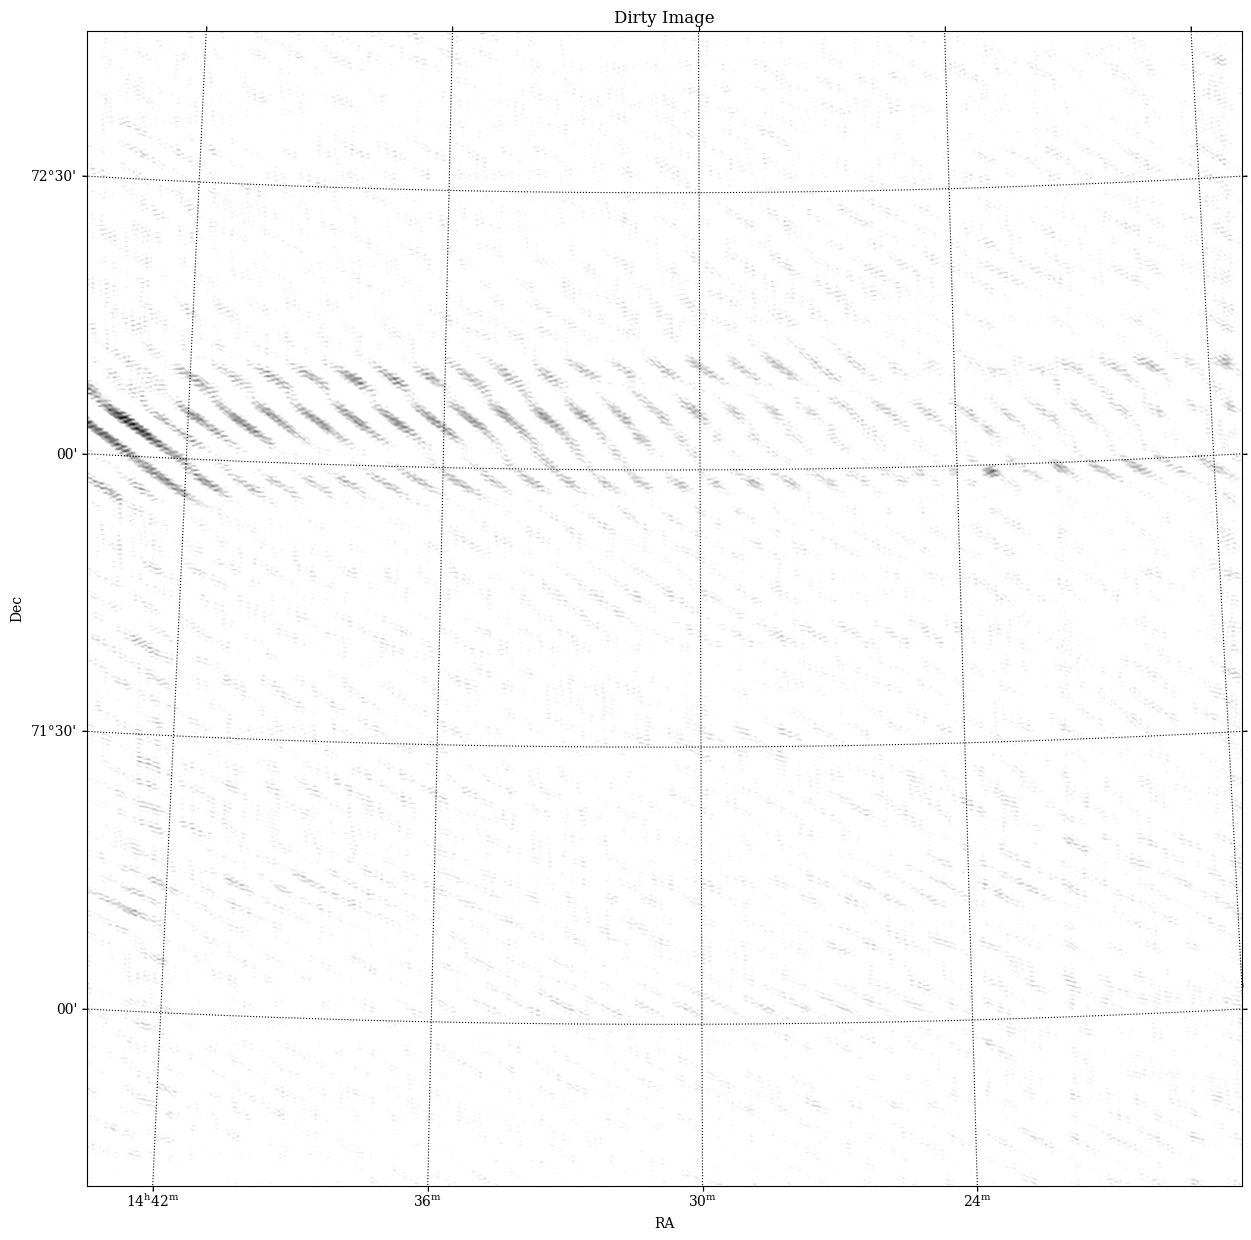

In [26]:
# Load the FITS image
#for fieldname in field_names:
#imagetype = 'dirty_briggs0.5_1500x3arc'
#imagename = f'{msfile.split(".ms")[0]}_{fieldname}_{imagetype}'
#fitsfile = os.path.join(basepath, imagename) + '.image.fits'
#fits_file = os.path.join(basepath, fitsfile)
#fits_file = '2025-02-26T19:31:53_ra332.0_dec+42.2_drift_ra22h05m22s_dirty_briggs0.5_1500x3arc.psf.image.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (15, 15))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
#norm = ImageNormalize(hdu.data[0, 0, :, :])#, interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmin = 0.1 * np.max(hdu.data[0, 0, :, :]), vmax = np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
#for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
#    circle = Circle((xi, yi), radius=10, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
#    ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Dirty Image')
plt.grid(color='k', ls='dotted')
plt.show()
